<파이썬 머신러닝 완벽 가이드 개정 2판> 8장 pg. 509 ~ 534

# CHAPTER 08. 텍스트 분류
---
## 08-04. 실습 - 20 뉴스그룹 분류
- ### 텍스트 정규화
- ### 피처 벡터화 변경과 머신러닝 모델 학습/예측/평가
- ### 사이킷런 파이프라인(Pipeline) 사용 및 GridSearchCV와의 결합
   
## 08-05. 감성 분석
- ### 감성 분석 소개
- ### 지도학습 기반 감성 분석 실습 - IMDB 영화평
- ### 비지도학습 기반 감성 분석 소개
- ### VADER를 이용한 감성 분석

---



## 08-04. 실습 - 20 뉴스그룹 분류


### 텍스트 정규화
- remove=('headers', 'footers', 'quotes')로 내용을 제외하고 제목 등의 다른 정보는 제거
- subset='train'으로 학습용 데이터 추출. subset='test'으로 테스트용 데이터 추출.



In [2]:
from sklearn.datasets import fetch_20newsgroups

# fetch_20newsgroups( )는 사이킷런의 다른 데이터 세트 예제와 같이 파이썬 딕셔너리와 유사한 Bunch 객체를 반환
news_data = fetch_20newsgroups(subset='all', random_state=156)

In [3]:
# 어떠한 key 값을 가지고 있는지 확인
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [4]:
# Target 클래스가 어떻게 구성돼 있는지 확인
import pandas as pd

print('target 클래스의 값과 분포도 \n', pd.Series(news_data.target).value_counts().sort_index())
print('target 클래스의 이름들 \n', news_data.target_names)

target 클래스의 값과 분포도 
 0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
Name: count, dtype: int64
target 클래스의 이름들 
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [5]:
# 개별 데이터가 텍스트로 어떻게 구성돼 있는지 데이터를 한 개만 추출해 값을 확인
print(news_data.data[0])

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
primary concern is complying with stupid helmet laws, carry a real big
spare (you can put a big or small head in a big helmet, bu

In [6]:
# 내용을 제외하고 제목 등의 다른 정보는 제거
from sklearn.datasets import fetch_20newsgroups

# subset='train'으로 학습용 데이터만 추출. remove=('headers', 'footers', 'quotes')로 내용만 추출
train_news = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), random_state=156)
X_train = train_news.data
y_train = train_news.target

# subset='test'으로 테스트 데이터만 추출. remove=('headers', 'footers', 'quotes')로 내용만 추출
test_news = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), random_state=156)
X_test = test_news.data
y_test = test_news.target

print('학습 데이터 크기 {0}, 테스트 데이터 크기 {1}'.format(len(train_news.data), len(test_news.data)))

학습 데이터 크기 11314, 테스트 데이터 크기 7532


### 피처 벡터화 변경과 머신러닝 모델 학습/예측/평가

[뼈대]

피처 벡터화
- 카운트 기반
- TF-IDF 기반

모델
- 로지스틱 회귀

[유의점]
- 테스트 데이터에서 CountVectorizer를 적용할 때는 반드시 학습 데이터를 이용해 fit()이
수행된 CountVectorizer 객체를 이용해 테스트 데이터를 변환(transform)해야만 학습 시 설정된 CountVectorizer의 피처 개수와 테스트 데이터를 CountVectorizer로 변환할
피처 개수가 같아짐.
- 즉, CountVectorizer.fit_transform(테스트 데이터)을 하면 학습 시 사용된 피처 개수와 예측 시
사용할 피처 개수가 달라짐.
- 텍스트 정규화나 Count/TF-IDF 기반 피처 벡
터화를 어떻게 효과적으로 적용했는지가 텍스트 기반의 머신러닝 성능에 큰 영향을 미침.



**카운트 기반 피처 벡터화**

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorization으로 피처 벡터화 변환 수행
cnt_vect = CountVectorizer()
cnt_vect.fit(X_train)
X_train_cnt_vect = cnt_vect.transform(X_train)

# 학습 데이터로 fit()된 CountVectorizer을 이용해 테스트 데이터를 피처 벡터화 변환 수행
## 11314개의 문서에서 피처, 즉 단어가 101631개로 만들어짐.
X_test_cnt_vect = cnt_vect.transform(X_test)

print('학습 데이터 텍스트의 CountVectorizer Shape:', X_train_cnt_vect.shape)

학습 데이터 텍스트의 CountVectorizer Shape: (11314, 101631)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# LogisticRegression을 이용하여 학습/예측/평가 수행
## Count 기반 피처 벡터화가 적용된 데이터 세트에 대한 로지스틱 회귀의 예측 정확도는 약 0.617.
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_cnt_vect, y_train)
pred = lr_clf.predict(X_test_cnt_vect)
print('CountVectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

CountVectorized Logistic Regression의 예측 정확도는 0.617


**TF-IDF 기반 기반 피처 벡터화**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화를 적용해 학습 데이터 세트와 테스트 데이터 세트 변환
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

# LogisticRegression을 이용해 학습/예측/평가 수행
## TF-IDF 벡터화가 적용된 데이터 세트에 대한 로지스틱 회귀의 예측 정확도는 단순 카운트 기반보다 훨씬 높음.
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Logistic Regression의 예측 정확도는 0.678


In [12]:
# stop words 필터링을 추가하고 ngram을 기본 (1, 1)에서 (1, 2)로 변경해 피처 벡터화 적용
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.690


In [13]:
from sklearn.model_selection import GridSearchCV

# 최적 C 값 도출 튜닝 수행. CV는 3 폴드 세트로 설정.
params = {'C': [0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_lr.fit(X_train_tfidf_vect, y_train)
print('Logistic Regression best C parameter :', grid_cv_lr.best_params_)

# 최적 C 값으로 학습된 grid_cv로 예측 및 정확도 평가.
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0: 3f}'.format(accuracy_score(y_test, pred)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression best C parameter : {'C': 10}
TF-IDF Vectorized Logistic Regression의 예측 정확도는  0.703930


### 사이킷런 파이프라인(Pipeline) 사용 및 GridSearchCV와의 결합

피처 벡터화 파라미터와 GridSearchCV 기반의 하이퍼 파라미터 튜닝을 한꺼번에 수행

[정의]
- 사이킷런의 Pipeline 클래스
   - 데이터의 전처리와 머신러닝 학습 과정을 통일된 API 기반에서 처리할 수 있어 더 직관적인 ML 모델 코드를 생성 가능
   - 대용량 데이터의 피처 벡터화 결과를 별도 데이터로 저장하지 않고 스트림 기반에서 바로 머신러닝 알고리즘의 데이터로 입력할 수 있기 때문에 수행 시간을 절약 가능
   - 모든 데이터 전처리 작업과 스케일링 또는 벡터 정규화, PCA 등의 변환작업과분류, 회귀 등의 Estimator 결합 가능

[유의점]
- Pipeline + GridSearchCV를 함께 적용하면 피처 벡터화에 사용되는 파라미터와 GridSearchCV 하이퍼 파라미터를 합치면 최적화를 위한 너무 많은 경우의 수가 발생하여 너무 많은 튜닝 시간이 소모됨.




In [ ]:
# pipeline = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english')),
#                     ('lr_clf', LogisticRegression(random_state=156))])

In [15]:
from sklearn.pipeline import Pipeline

# TfidfVectorizer 객체를 tfidf_vect로, LogisticRegression 객체를 lr_clf로 생성하는 Pipeline 생성
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))
])

In [16]:
# 별도의 TfidfVectorizer 객체의 fit(), transform()과 LogisticRegression의 fit(), predict()가 필요없음.
# pipeline의 fit()과 predict()만으로 한꺼번에 피처 벡터화와 ML 학습/예측이 가능
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Pipeline을 통한 Logistic Regression의 예측 정확도는 0.704


In [19]:
# from sklearn.pipeline import Pipeline

# pipeline = Pipeline([
#     ('tfidf_vect', TfidfVectorizer(stop_words='english')),
#     ('lr_clf', LogisticRegression())
# ])

# # Pipeline에 기술된 각각의 객체 변수에 언더바(_)를 2개 연달아 붙여 GridSearchCV에 사용될 파라미터/하이퍼 파라미터 이름곽 값을 설정
# params = {'tfidf_vect__ngram_range': [(1,1), (1,2), (1,3)],
#           'tfidf_vect__max_df':[100, 300, 700],
#           'lr_clf__C':[1, 5, 10]}

# # GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
# grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1)
# grid_cv_pipe.fit(X_train, y_train)
# print(grid_cv_pipe.best_params_, grid_cv_pipe.best_score_)

# pred = grid_cv_pipe.predict(X_test)
# print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

## 08-05. 감성 분석


### 감성 분석 소개
[정의]
- 감성 분석(Sentiment Analysis): 문서 내 텍스트가 나타내는 여러 가지 주관적인 단어와 문맥을 기반으로 감성(Sentiment) 수치를 계산하는 방법
   - 지도학습: 일반적인 텍스트 기반의 분류와 거의 동일
   - 비지도학습: 감성 분석 다양한 정보를 가지고 있는 ‘Lexicon’이라는 감성 어휘 사전을 이용. 문서의 긍정적, 부정적 감성 여부를 판단.

### 지도학습 기반 감성 분석 실습 - IMDB 영화평



In [20]:
import pandas as pd

review_df = pd.read_csv('/content/labeledTrainData[1].tsv', header=0, sep='\t', quoting=3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [21]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [24]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# 파이썬의 정규 표현식 모듈인 re를 이용해 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

In [25]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id', 'sentiment'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3, random_state=156)
X_train.shape, X_test.shape

((17500, 1), (7500, 1))

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드 English, ngram은 (1, 2)로 설정해 CountVectorization 수행.
# LogisticRegression의 C는 10d으로 설정.
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행. predict_proba()는 roc_auc 때문에 수행.
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred), roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8861, ROC-AUC는 0.9503


In [27]:
# 스톱 워드는 english, filtering, ngram은 (1, 2)로 설정해 TF-IDF 벡터화 수행.
# LogisticRegression의 C는 10으로 설정.
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred), roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


### 비지도학습 기반 감성 분석 소개
- Synset은 단순한 하나의 단어가 아니라 그 단어가 가지
는문맥, 시맨틱 정보를 제공하는 WordNet의 핵심 개념
- NLTK를 포함한 대표적인 감성 사전
   - SentiWordNet: WordNet의 Synset별로 3가지 감성 점수(sentiment score : 긍정 감성 지수, 부정 감성 지수, 객관성 지수)를 할당
   - VADER: 뛰어난 감성 분석 결과를 제공
   - Pattern

**WordNet Synset와 SentiWordNet SentiSynet 클래스의 이해**

In [28]:
# NLTK의 모든 데이터 세트와 패키지를 다운로드
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [29]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성.
synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 갯수:', len(synsets))
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 갯수: 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


In [30]:
# synset 객체가 가지는 여러 가지 속성
for synset in synsets:
  print('##### Synset name : ', synset.name(), '#####')
  print('POS :', synset.lexname())
  print('Definition :', synset.definition())
  print('Lemmas :', synset.lemma_names())

##### Synset name :  present.n.01 #####
POS : noun.time
Definition : the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas : ['present', 'nowadays']
##### Synset name :  present.n.02 #####
POS : noun.possession
Definition : something presented as a gift
Lemmas : ['present']
##### Synset name :  present.n.03 #####
POS : noun.communication
Definition : a verb tense that expresses actions or states at the time of speaking
Lemmas : ['present', 'present_tense']
##### Synset name :  show.v.01 #####
POS : verb.perception
Definition : give an exhibition of to an interested audience
Lemmas : ['show', 'demo', 'exhibit', 'present', 'demonstrate']
##### Synset name :  present.v.02 #####
POS : verb.communication
Definition : bring forward and present to the mind
Lemmas : ['present', 'represent', 'lay_out']
##### Synset name :  stage.v.01 #####
POS : verb.creation
Definition : perform (a play), especially on a stage
Lemmas : ['stage', 'present

In [31]:
# synset 객체를 단어별로 생성합니다.
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree, lion, tiger, cat, dog]
similarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset과 유사도를 측정한다.
for entity in entities:
  similarity = [round(entity.path_similarity(compared_entity), 2) for compared_entity in entities]
  similarities.append(similarity)

# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFrame 형태로 저장한다.
similarity_df = pd.DataFrame(similarities, columns=entity_names, index=entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


In [32]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type :', type(senti_synsets))
print('senti_synsets() 반환 값 갯수:', len(senti_synsets))
print('senti_synsets() 반환 값 :', senti_synsets)

senti_synsets() 반환 type : <class 'list'>
senti_synsets() 반환 값 갯수: 11
senti_synsets() 반환 값 : [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


In [33]:
# father(아버지)라는 단어와 fabulous(아주 멋진)라는 두 개 단어의 감성 지수와 객관성 지수
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수: ', father.pos_score())
print('father 부정감성 지수: ', father.neg_score())
print('father 객관성 지수: ', father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수: ', fabulous.pos_score())
print('fabulous 부정감성 지수: ', fabulous.neg_score())

father 긍정감성 지수:  0.0
father 부정감성 지수:  0.0
father 객관성 지수:  1.0


fabulous 긍정감성 지수:  0.875
fabulous 부정감성 지수:  0.125


**SentiWordNet을 이용한 영화 감상평 감성 분석**
1.  문서(Document)를 문장(Sentence) 단위로 분해
2.  다시 문장을 단어(Word) 단위로 토큰화하고 품사 태깅
3. 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
4. senti_synset 객체에서 긍정 감성/부정 감성 지수를 구하고 이를 모두 합산해 특정 임계치 값 이상일 때 긍정 감성으로, 그렇지 않을 때는 부정 감성으로 결정


In [34]:
from nltk.corpus import wordnet as wn

# 간단한 NLTK PennTreebank Tag를 기반으로 WordNet 기반의 품사 Tag로 변환
def penn_to_wn(tag):
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB

In [35]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
  # 감성 지수 초기화
  sentiment = 0.0
  tokens_count = 0

  lemmatizer = WordNetLemmatizer()
  raw_sentences = sent_tokenize(text)
  # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산
  for raw_sentence in raw_sentences:
    # NTLK 기반의 품사 태깅 문장 추출
    tagged_sentence = pos_tag(word_tokenize(raw_sentence))
    for word, tag in tagged_sentence:

      # WordNet 기반 품사 태깅과 어근 추출
      wn_tag = penn_to_wn(tag)
      if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        continue
      lemma = lemmatizer.lemmatize(word, pos=wn_tag)
      if not lemma:
        continue
      # 어근을 추출한 단어의 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성.
      synsets = wn.synsets(lemma, pos=wn_tag)
      if not synsets:
        continue
      # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
      # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산.
      synset = synsets[0]
      swn_synset = swn.senti_synset(synset.name())
      sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
      tokens_count += 1

  if not tokens_count:
    return 0

  # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
  if sentiment >= 0:
    return 1

  return 0

In [36]:
# swn_polarity(text) 함수를 IMDB 감상평의 개별 문서에 적용해 긍정 및 부정 감성을 예측
review_df['preds'] = review_df['review'].apply(lambda x: swn_polarity(x))
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [37]:
# SentiWordNet의 감성 분석 예측 성능
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print("정확도 : ", np.round(accuracy_score(y_target, preds), 4))
print("정밀도: ", np.round(precision_score(y_target, preds), 4))
print("재현율: ", np.round(recall_score(y_target, preds), 4))

[[7669 4831]
 [3635 8865]]
정확도 :  0.6614
정밀도:  0.6473
재현율:  0.7092


### VADER를 이용한 감성 분석


In [38]:
# NLTK 서브 모듈로 SentimentlntensityAnalyzer를 임포트하고 간략하게 IMDB의 감상평 한 개만 감성 분석을 수행
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [39]:
# VADER를 이용해 IMDB의 감성 분석을 수행
def vader_polarity(review, threshold=0.1):
  analyzer = SentimentIntensityAnalyzer()
  scores = analyzer.polarity_scores(review)

  # compound 값에 기반해 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
  agg_score = scores['compound']
  final_sentiment = 1 if agg_score >= threshold else 0
  return final_sentiment

# apply lambda 식을 이용해 레코드별로 vader_polarity()를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply(lambda x: vader_polarity(x, 0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix(y_target, vader_preds))
print("정확도:", np.round(accuracy_score(y_target, vader_preds), 4))
print("정밀도:", np.round(precision_score(y_target, vader_preds), 4))
print("재현율:", np.round(recall_score(y_target, vader_preds), 4))

[[ 6747  5753]
 [ 1858 10642]]
정확도: 0.6956
정밀도: 0.6491
재현율: 0.8514


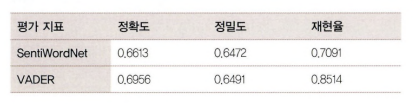